# On the use of Deep Generative Models for "Perfect" Prognosis Climate Downscaling

This notebook trains a CVAE model for the Statistical Downscaling of precipitation. This part of the analysis is written in Python and uses Pytorch as framework for the Deep Learning models.

First load the required libraries and set the data and model paths

In [1]:
import os
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import netCDF4
import sklearn.metrics as metrics
import subprocess
from wand.image import Image as WImage
import lib.utils as utils
import lib.models as models
import lib.data as data
import lib.loss as loss
import lib.train as train

DATA_PATH = './data/'
MODELS_PATH = './models/'

Load the preprocessed data from R and convert it to Numpy arrays

In [11]:
base = importr('base')
base.load(DATA_PATH + 'x_train.RData')
base.load(DATA_PATH + 'y_train.RData')

x_train = np.array(robjects.r['x_train'])
y_train = np.array(robjects.r['y_train'])

Randomly split the training set into training and validation

In [5]:
percSample = 0.1
idxs = list(range(x_train.shape[0]))
np.random.shuffle(idxs)

x_aux = np.array(x_train[idxs, :, :, :], copy = True)
y_aux = np.array(y_train[idxs, :], copy = True)

split_threshold = round((1 - percSample) * len(idxs))

x_train = x_aux[:split_threshold, :, :, :]
y_train = y_aux[:split_threshold, :]

x_valid = x_aux[split_threshold:, :, :, :]
y_valid = y_aux[split_threshold:, :]

Load the model to train, in this case the CVAE

In [6]:
model = models.cVAE(spatial_x_dim = x_train.shape[2] * x_train.shape[3],
                    out_dim = y_train.shape[1])
print(model)

cVAE(
  (encoderX): Sequential(
    (0): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(25, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.3, inplace=False)
  )
  (encoder): Sequential(
    (0): Linear(in_features=3661, out_features=2000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2000, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=500, bias=True)
  )
  (encoderY_mu): Linear(in_features=500, out_features=500, bias=True)
  (encoderY_logvar): Linear(in_features=500, out_features=500, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=918, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_feat

Instantiate the train and validation DataLoaders

In [7]:
trainDataset = data.MyDataset(x_train, y_train)
trainDataloader = DataLoader(trainDataset, batch_size = 32,
                             shuffle = True)

validDataset = data.MyDataset(x_valid, y_valid)
validDataloader = DataLoader(validDataset, batch_size = 1,
                             shuffle = True)

As optimizer we use Adam with a learning rate of 0.00001

In [8]:
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

As loss function we use a standard VAE loss function (Reconstruction + KL) using L2 loss as reconstruction function (MSE)

In [ ]:
lossTrain = loss.lossVAE

We use a learning rate scheduler to reduce the learning metric when the model stops learning

In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode = 'min',
                              factor = 0.5, patience = 30,
                              verbose = True)

Finally we can train the model. We train the model until the loss function stops decreasing after 60 epochs. A trained version of the model is already included. The training can be ommited by commenting the following cell, in this case the included model will be used to compute the predictions.

In [ ]:
train.train_model(model = model, modelName = 'CVAE',
                  loss_function = lossTrain, optimizer = optimizer,
                  num_epochs = 10000, patience = 60,
                  trainData = trainDataloader,
                  validData = validDataloader,
                  scheduler = scheduler)

Load the test set

In [9]:
base.load(DATA_PATH + 'x_test.RData')
base.load(DATA_PATH + 'y_test.RData')

x_test = np.array(robjects.r['x_test'])
y_test = np.array(robjects.r['y_test'])

Compute predictions over the full test set and save them into `npy` files

In [10]:
utils.computeRData(x_test, y_test, model, modelName = 'CVAE')

Launch the R script finalFigures.R. This script loads Stochastic Downscales Fields (CVAE predictions) from the CVAE model for an specific day and visually compare them against the real observation. A PDF file will be generated at `./figures/`

In [7]:
subprocess.call(['/usr/bin/Rscript', 'finalFigures.R'])

0

Show the PDF figure computed in the previous cell

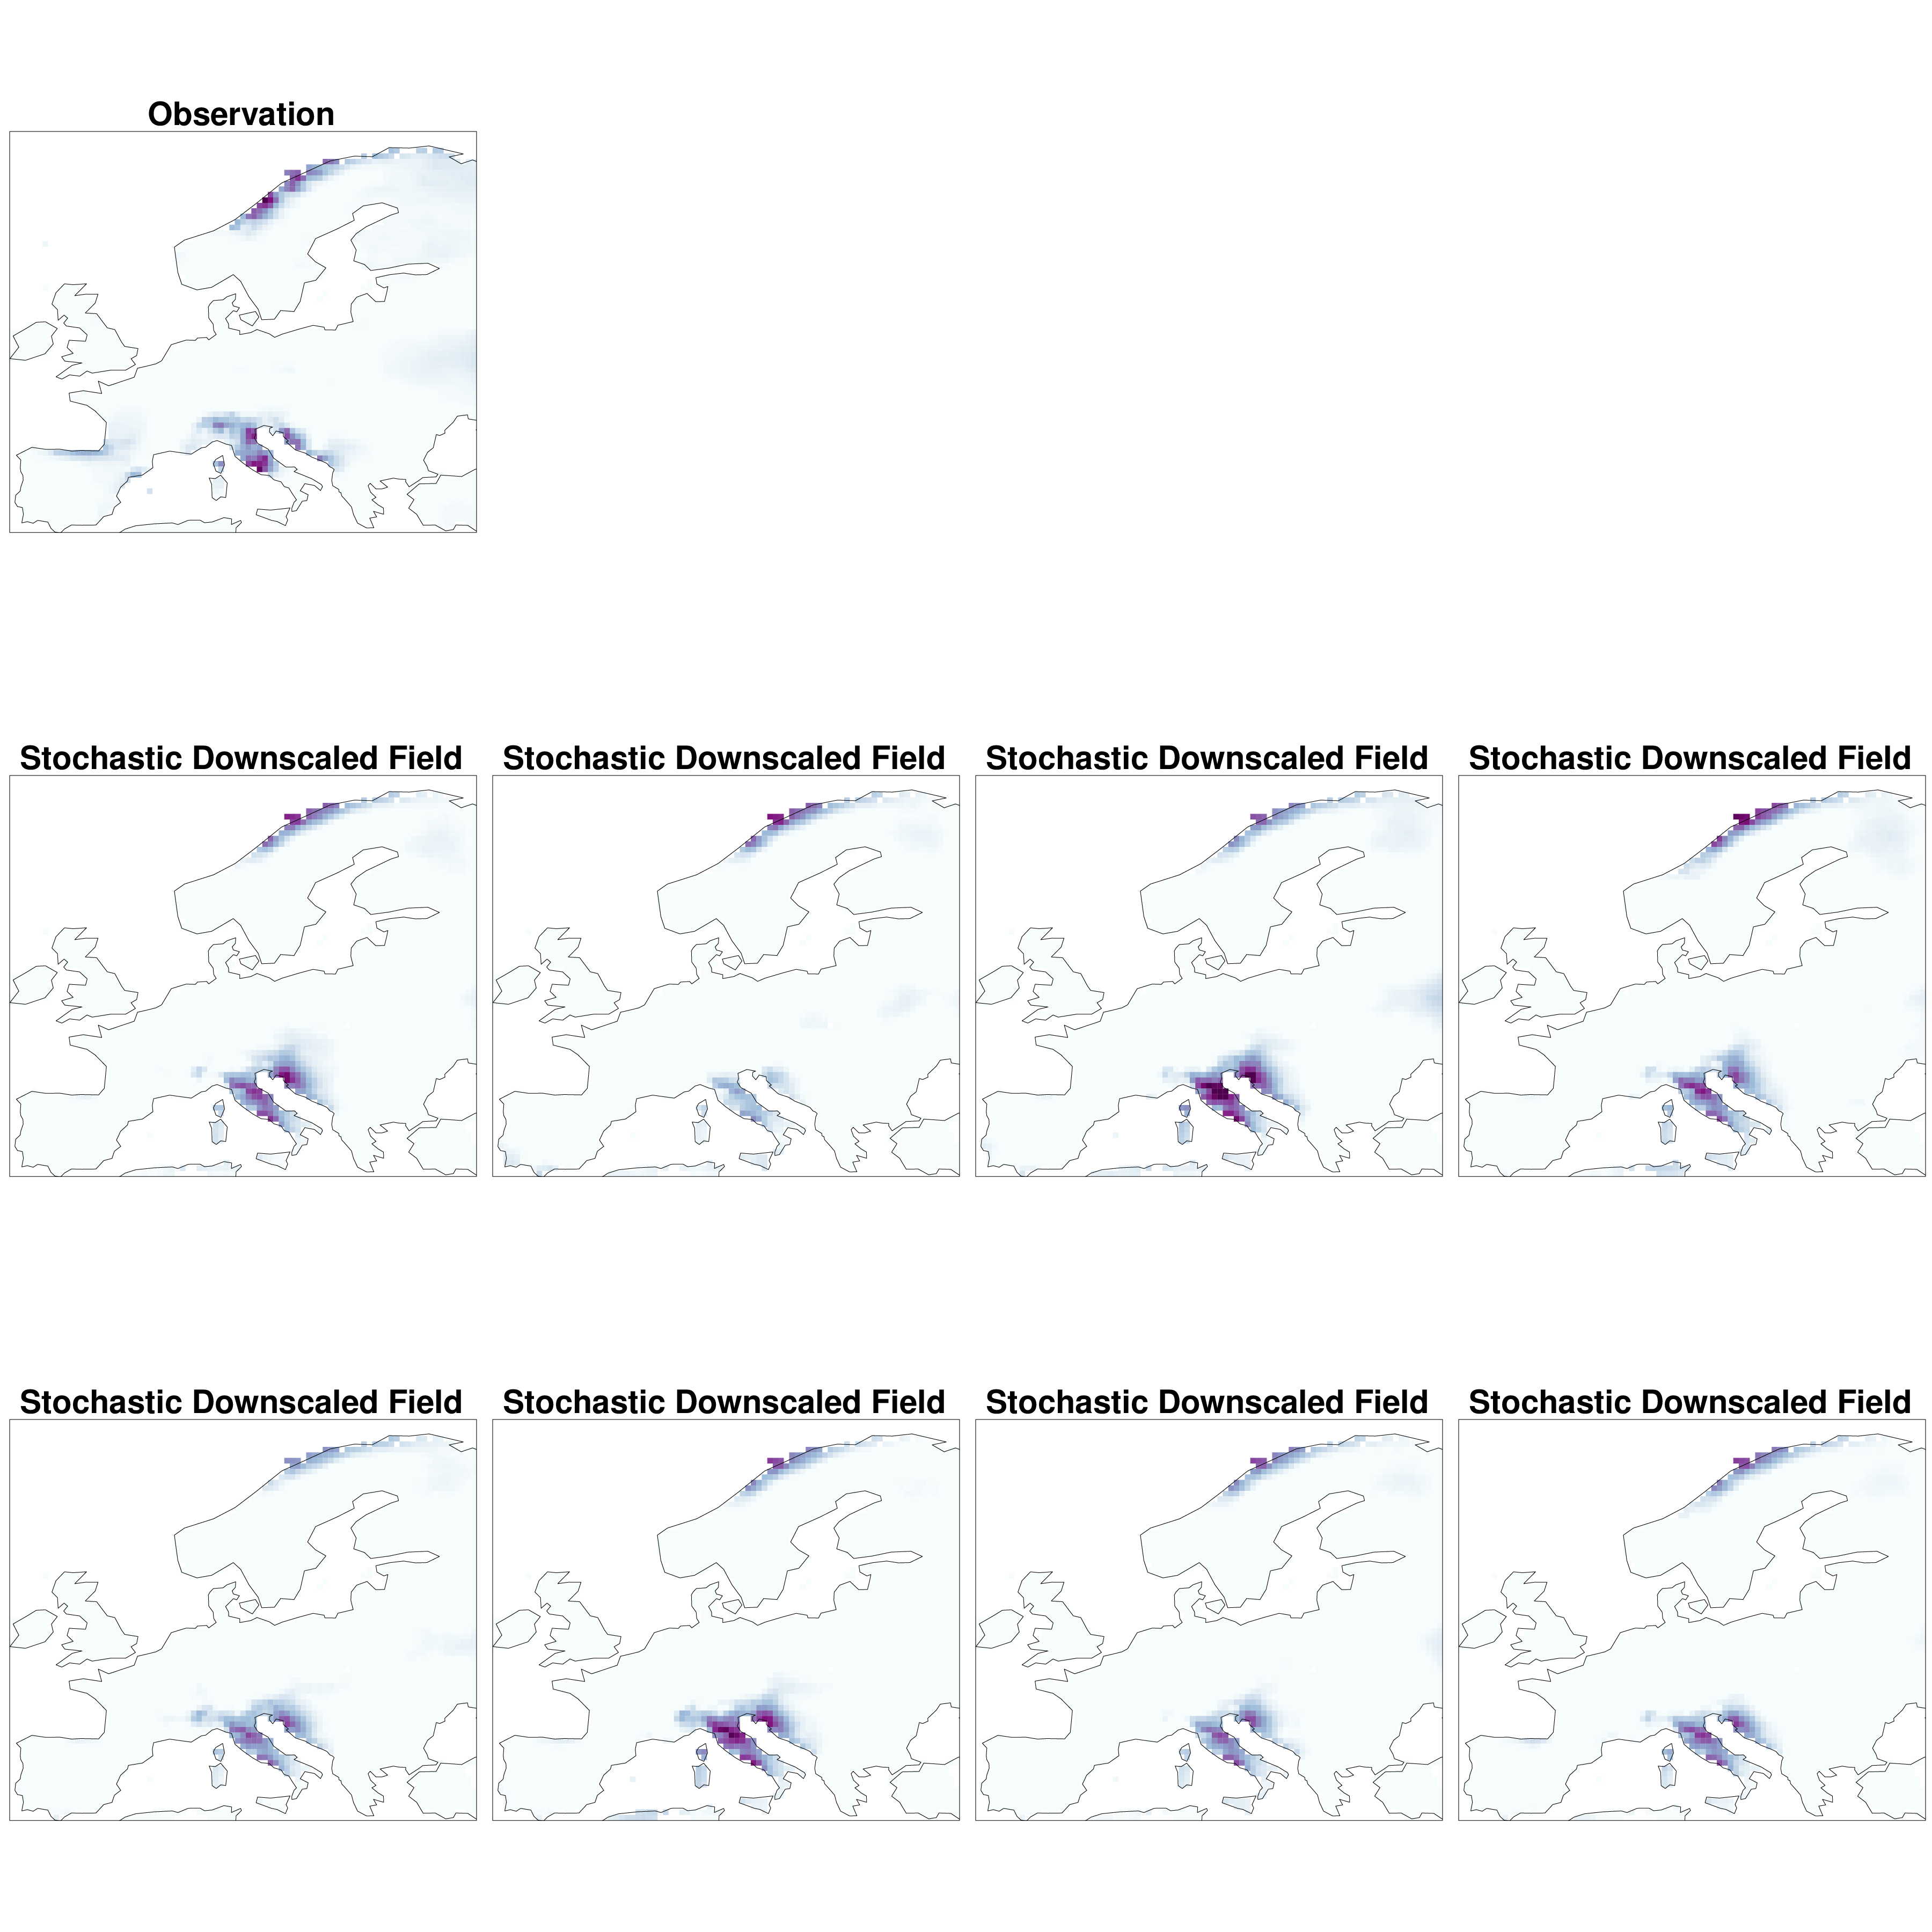

In [8]:
img = WImage(filename = './figures/CVAE.pdf')
img